# Anomaly detection with Convolutional Autoencoder (CAE)

The goal of this approach is to train a model on the "not fractured" data and then use it to detect anomalies (fractures).

## Data preparation

In [41]:
from PIL import Image, ImageFile
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg"):  # Filter for jpg files
            try:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(target_size)  # Resize image to (224, 224)
                img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
            except OSError as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images)

## Load and preprocess data

In [6]:
# Path to the "not fractured" images
train_folder = './raw data/not fractured/img'
train_images = load_images_from_folder(train_folder, target_size=(224, 224))

# Path to the "val" images
val_folder = './raw data/val/img'
val_images = load_images_from_folder(val_folder, target_size=(224, 224))

In [8]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [12]:
def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg"):
            img = Image.open(img_path).convert('RGB')  # Ensure it's in RGB
            img = img.resize(target_size)  # Resize image to (128, 128)
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
    return np.array(images)

In [13]:
# Load the training data (not fractured images)
train_folder = './raw data/not fractured/img'  # Path to your "not fractured" images
train_images = load_images_from_folder(train_folder)

# Load the validation/test data (val images)
val_folder = './raw data/val/img'  # Path to your "val" images
val_images = load_images_from_folder(val_folder)

## Train Autoencoder

In [16]:
input_shape = (224, 224, 3)                            
autoencoder = build_autoencoder(input_shape)

# Train the model on the "not fractured" images
autoencoder.fit(train_images, train_images, epochs=20, batch_size=32, validation_data=(val_images, val_images))
# Save the trained model
autoencoder.save('autoencoder_model.h5')

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - loss: 0.0818 - val_loss: 0.0759
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - loss: 0.0776 - val_loss: 0.0759
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - loss: 0.0767 - val_loss: 0.0759
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 105s 990ms/step - loss: 0.0763 - val_loss: 0.0759
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 0.0763 - val_loss: 0.0753
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0370 - val_loss: 0.0018
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 0.0010 - val_loss: 8.0897e-04
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 7.9909e-04 - val_loss: 7.1107e-04
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 6.7768e-04 - val_loss: 6.8401e-04
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 6.1023e-04 - val_loss: 5.5847e-04
Epoch 12/2

## Evaluate Anomalies

In [90]:
def calculate_reconstruction_error(model, images):
    reconstructed_images = model.predict(images)
    reconstruction_error = np.mean(np.abs(images - reconstructed_images), axis=(1, 2, 3))  # Mean absolute error per image
    return reconstruction_error

# Calculate reconstruction error on the "val" images (anomalies)
val_reconstruction_error = calculate_reconstruction_error(autoencoder, val_images)

# Set a threshold for anomaly detection (you can experiment with this)
threshold = 0.005

# Find the images with reconstruction error above the threshold
anomalies = val_reconstruction_error > threshold
print(f"Anomalies detected: {np.sum(anomalies)} out of {len(val_images)}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Anomalies detected: 82 out of 82


In [98]:
def plot_anomalies_with_heatmap(images, reconstructed_images, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))

    for i in range(min(num_images, len(images))):
        # Original image
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Calculate reconstruction error (mean absolute error)
        error = np.mean(np.abs(images[i] - reconstructed_images[i]), axis=-1)

        # Normalize error to [0, 1] range
        error_normalized = (error - np.min(error)) / (np.max(error) - np.min(error))

        # Plot the heatmap on top of the image
        heatmap = axes[1, i].imshow(images[i], cmap='gray')
        axes[1, i].imshow(error_normalized, cmap='jet', alpha=0.5)  # Overlay heatmap with some transparency
        axes[1, i].set_title(f"Reconstructed with Heatmap {i+1}")
        axes[1, i].axis('off')

        # Colorbar for heatmap
        plt.colorbar(heatmap, ax=axes[1, i])

    plt.show()

In [100]:
def plot_anomalies_with_heatmap(images, reconstructed_images, num_images=10):
    num_images = min(num_images, len(images))  # Ensure we don't exceed the available images
    fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 4))  # Adjust figure size for better visibility

    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        # Calculate reconstruction error (mean absolute error)
        error = np.mean(np.abs(images[i] - reconstructed_images[i]), axis=-1)

        # Normalize error to [0, 1] range
        error_normalized = (error - np.min(error)) / (np.max(error) - np.min(error))

        # Plot the reconstructed image with the heatmap overlay
        axes[i, 1].imshow(images[i], cmap='gray')  # Show original structure in grayscale
        heatmap = axes[i, 1].imshow(error_normalized, cmap='jet', alpha=0.5)  # Overlay heatmap
        axes[i, 1].set_title(f"Reconstructed with Heatmap {i+1}")
        axes[i, 1].axis('off')

        # Add colorbar
        fig.colorbar(heatmap, ax=axes[i, 1])

    plt.tight_layout()
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


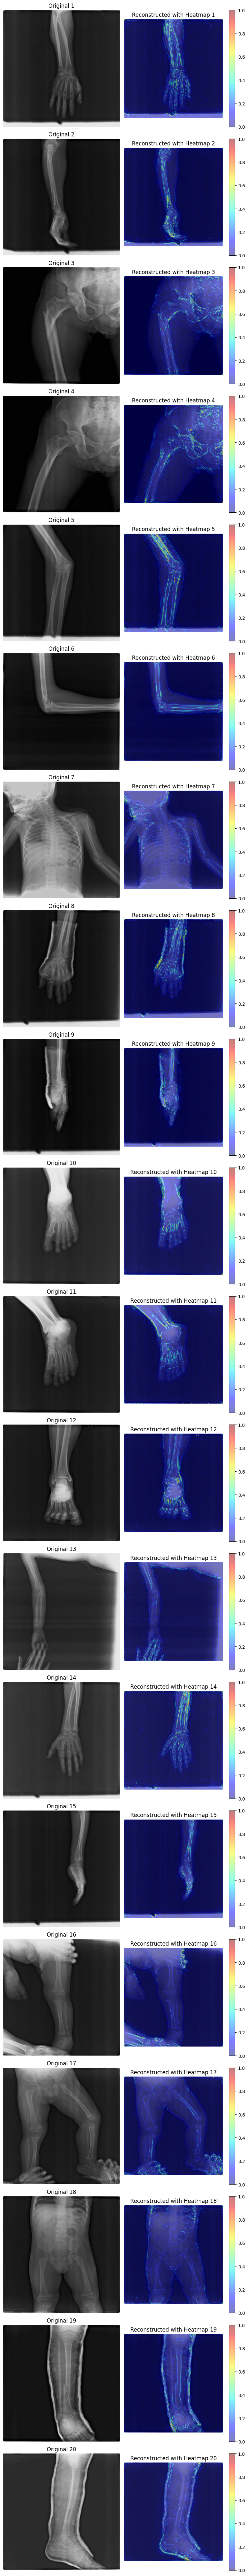

In [104]:
# Get reconstructed images
reconstructed_images = autoencoder.predict(val_images)

# Plot anomalies with heatmap
plot_anomalies_with_heatmap(val_images, autoencoder.predict(val_images), num_images=20)

Original 19 shows clearly that the anomalies do not detect the fractures.